In [2]:
# === BIBLIOTECAS NECESSÁRIAS ===
# Manipulação de dados e cálculos numéricos
import pandas as pd 
import numpy as np  
# Visualização estática (gráficos tradicionais)
import matplotlib.pyplot as plt 
import seaborn as sns            
# Manipulação de datas
from datetime import datetime  
# Visualização interativa e dinâmica
import plotly.express as px     
import plotly.graph_objects as go 
from plotly.subplots import make_subplots 
# Manipulação de arquivos e sistemas
import glob
import os  
# Expressões regulares
import re 

In [15]:
# 1) Carregar e concatenar os dados dos processos judiciais da pasta uploads
# Exibição no console
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 200)

# Listar os arquivos CSV na pasta 'uploads'
arquivos_csv = glob.glob('uploads/processos_*.csv')

# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
tamanho_total_bytes = 0   # Somar os tamanhos dos arquivos
for arquivo in arquivos_csv:
    # Extrair o ano do nome do arquivo
    ano = int(arquivo.split('_')[-1].split('.')[0])
    
    # Soma o tamanho de cada arquivo à variável
    tamanho_total_bytes += os.path.getsize(arquivo)
    
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    df_ano['ano_arquivo'] = ano  # Adicionar coluna com o ano do arquivo
    dfs.append(df_ano)

print("\n=== Arquivo carregado com sucesso! ===")
df_juridico = pd.concat(dfs, ignore_index=True)
print("Dimensões (linhas, colunas):", df_juridico.shape)

# Tamanho do arquivo
file_size_mb = tamanho_total_bytes / (1024**2)
print(f"Tamanho total dos arquivos CSV no disco: {file_size_mb:.2f} MB")

# Verificação de valores vazios ou nulos no DataFrame df_juridico
print("\n=== Verificação de Valores Nulos/Vazios ===")

# Contar o total de valores nulos por coluna
valores_nulos_por_coluna = df_juridico.isnull().sum()

# Filtrar para mostrar apenas as colunas que de fato contêm valores nulos
colunas_com_nulos = valores_nulos_por_coluna[valores_nulos_por_coluna > 0]

if colunas_com_nulos.empty:
    print("Não foram encontrados valores nulos ou vazios no DataFrame.")
else:
    print("Foram encontrados valores nulos nas seguintes colunas:")
    
    # Criar um DataFrame de resumo para uma visualização clara
    total_registros = len(df_juridico)
    df_resumo_nulos = pd.DataFrame({
        'Qtd Nulos': colunas_com_nulos,
        'Percentual (%)': (colunas_com_nulos / total_registros) * 100
    })
    
    # Ordenar o resultado pela coluna de percentual, do maior para o menor
    df_resumo_nulos_sorted = df_resumo_nulos.sort_values(by='Percentual (%)', ascending=False)
    
    # Formatar a coluna de percentual para exibir com duas casas decimais e o símbolo '%'
    df_resumo_nulos_sorted['Percentual (%)'] = df_resumo_nulos_sorted['Percentual (%)'].map('{:.2f}%'.format)
    
    # Exibir a tabela-resumo
    print(df_resumo_nulos_sorted)

# Guardar uma cópia de trabalho
df = df_juridico.copy()


=== Arquivo carregado com sucesso! ===
Dimensões (linhas, colunas): (4944351, 11)
Tamanho total dos arquivos CSV no disco: 726.09 MB

=== Verificação de Valores Nulos/Vazios ===
Foram encontrados valores nulos nas seguintes colunas:
             Qtd Nulos Percentual (%)
data_baixa     1749238         35.38%
codg_classe          2          0.00%


In [ ]:
# 2) Tratamento dos Dados para Advogados
# Tratamento das colunas
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['ano_distribuicao'] = df['data_distribuicao'].dt.year # Criar coluna de ano de distribuição
df['is_segredo_justica'] = df['is_segredo_justica'].astype(bool)

# Tratamento dos números de OAB
def is_oab_valida(oab):
    """
    Verifica se um número de OAB é válido seguindo o formato:
    NÚMEROS + LETRA + ESPAÇO + UF. Ex: '2153421N GO'
    """
    if not isinstance(oab, str) or not oab.strip():
        return False
    oab_limpa = oab.upper().strip()
    ufs_validas = ['GO', 'DF', 'SP', 'RJ', 'MG', 'RS', 'SC', 'PR', 'BA', 'PE',
                  'CE', 'MA', 'ES', 'AL', 'SE', 'PB', 'RN', 'PI', 'MT', 'MS', 
                  'TO', 'PA', 'AP', 'AM', 'RR', 'AC', 'RO'
                  ]
    padrao_regex = re.compile(f"^[1-9]\\d*[A-Z]\\s({'|'.join(ufs_validas)})$")
    return bool(padrao_regex.match(oab_limpa))

# Aplicar a validação de OAB
df['oab_valida'] = df['oab'].apply(is_oab_valida)

# Contar e exibir a quantidade de OABs inválidas
registros_invalidos = df[df['oab_valida'] == False]
qtd_invalidos = len(registros_invalidos)

print("\n=== Validação de Registros de OAB ===")
print(f"Total de registros com OAB em formato inválido ou nulo: {qtd_invalidos}")

if qtd_invalidos > 0:
    exemplos_invalidos = registros_invalidos['oab'].unique()
    print(f"Exemplos de OABs inválidas: {exemplos_invalidos}")
print("\n" + "="*100 + "\n")

# Dataframe com apenas OABs válidas
df_validos = df[df['oab_valida'] == True].copy()

# Verificar se valores NULL ou Vazios

print("\n=== Dataframe com apenas OAB's válidas ===")
display(df_validos.head())





=== Validação de Registros de OAB ===
Total de registros com OAB em formato inválido ou nulo: 20335
Exemplos de OABs inválidas: ['GO' '0A RJ' '0A MT' '0S GO' '0A MG' '0S MT' '0S DF' '0S MA' '0A PE' 'TO'
 '0A MS' '0S AL' '0S CE' '0S SC' '0S MG' '0S MS' '0S RS' '0S RN' '0A TO'
 '0A SE' '0S PE' '0A RS' '0S TO']



=== Dataframe com apenas OAB's válidas ===


,processo,data_distribuicao,data_baixa,entrancia,comarca,serventia,is_segredo_justica,codg_classe,oab,codg_assunto,ano_arquivo,ano_distribuicao,oab_valida
0,0119071.75.2004.8.09.0051,2022-05-25,2022-06-30,FINAL,GOIÂNIA,2ª Vara Cível,False,7.0,19365N GO,10671,2022,2022,True
1,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,10647N GO,10671,2022,2022,True
2,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,167974A SP,10671,2022,2022,True
3,0189657.40.2004.8.09.0051,2022-06-02,2024-01-22,FINAL,GOIÂNIA,31ª Vara Cível,False,7.0,20763N GO,10671,2022,2022,True
4,0197944.89.2004.8.09.0051,2022-06-07,2022-10-07,FINAL,GOIÂNIA,22ª Vara Cível,False,7.0,20785N GO,10671,2022,2022,True


In [14]:
# 3) Análise de Processos Sigilosos e Não Sigilosos por OAB válida
# Agrupar por 'oab' e 'is_segredo_justica' e contar a quantidade de processos
df_analise = df_validos.groupby(['oab', 'is_segredo_justica']).size().reset_index(name='qtd_processos')

# Ordenar os resultados para melhor visualização (pela OAB e depois pela quantidade)
df_analise_sorted = df_analise.sort_values(by=['oab', 'qtd_processos'], ascending=[True, False])

print("\n=== Tabela de Processos Sigilosos e Não Sigilosos por OAB ===")
display(df_analise_sorted.head(10))

# Para uma visualização mais clara, "pivotei" a tabela
# Criando colunas separadas para processos sigilosos e não sigilosos
df_pivot = df_analise.pivot_table(
    index='oab',
    columns='is_segredo_justica',
    values='qtd_processos',
    fill_value=0 # Preenche com 0 OABs que não têm um dos tipos
)

# Renomear as colunas (False -> nao_sigilosos, True -> sigilosos)
df_pivot = df_pivot.rename(columns={False: 'nao_sigilosos', True: 'sigilosos'})

# Adicionar uma coluna de total e ordenar pelos advogados com mais processos
df_pivot['total_processos'] = df_pivot['nao_sigilosos'] + df_pivot['sigilosos']
df_pivot_sorted = df_pivot.sort_values(by='total_processos', ascending=False)


print("\n=== Tabela Pivotada: Contagem por OAB ===")
display(df_pivot_sorted.head(10))


=== Tabela de Processos Sigilosos e Não Sigilosos por OAB ===


,oab,is_segredo_justica,qtd_processos
0,100005A PR,False,8
1,100006A PR,False,2
2,100006S RS,False,17
3,100008A RJ,True,1
4,10000N GO,False,16
5,100018A RS,False,1
6,10001A DF,False,1
7,10001A MS,False,1
8,10001A TO,False,1
9,10001N GO,False,58



=== Tabela Pivotada: Contagem por OAB ===


is_segredo_justica,nao_sigilosos,sigilosos,total_processos
oab,,,
16315N GO,86839.0,439.0,87278.0
21735N GO,71783.0,1548.0,73331.0
40240N GO,69514.0,1239.0,70753.0
38664N GO,43965.0,3617.0,47582.0
36056N GO,29732.0,518.0,30250.0
28449A GO,28525.0,683.0,29208.0
9632N GO,28435.0,4.0,28439.0
19417N GO,28226.0,3.0,28229.0
31989N GO,25473.0,232.0,25705.0


In [16]:
# 4) Cálculo de Estatísticas Descritivas
print("=== ESTATÍSTICAS DESCRITIVAS DE PROCESSOS POR OAB VÁLIDA ===")

# Análise Geral (Total de Processos)
# Distribuição do número total de processos por advogado.
print("--- Análise Geral (Total de Processos por OAB) ---")
total_counts = df_pivot_sorted['total_processos']

# Cálculo das métricas
media_geral = total_counts.mean()
mediana_geral = total_counts.median()
moda_geral = total_counts.mode()

print(f"Média de processos por OAB: {media_geral:.2f}")
print(f"Mediana de processos por OAB: {mediana_geral}")
# A moda pode retornar múltiplos valores se houver empate; pegamos o primeiro.
if not moda_geral.empty:
    print(f"Moda de processos por OAB: {moda_geral.iloc[0]}")
else:
    print("Moda: Não há um valor único que seja o mais frequente.")


# Análise de Processos NÃO SIGILOSOS
# Foco na distribuição de processos públicos por advogado.
print("\n--- Análise de Processos NÃO SIGILOSOS por OAB ---")
nao_sigilosos_counts = df_pivot_sorted['nao_sigilosos']

# Cálculo das métricas
media_nao_sigilosos = nao_sigilosos_counts.mean()
mediana_nao_sigilosos = nao_sigilosos_counts.median()
moda_nao_sigilosos = nao_sigilosos_counts.mode()

print(f"Média de processos não sigilosos por OAB: {media_nao_sigilosos:.2f}")
print(f"Mediana de processos não sigilosos por OAB: {mediana_nao_sigilosos}")
if not moda_nao_sigilosos.empty:
    print(f"Moda de processos não sigilosos por OAB: {moda_nao_sigilosos.iloc[0]}")
else:
    print("Moda: Não há um valor único que seja o mais frequente.")


# Análise de Processos SIGILOSOS
# Foco na distribuição de processos em segredo de justiça por advogado.
print("\n--- Análise de Processos SIGILOSOS por OAB ---")
sigilosos_counts = df_pivot_sorted['sigilosos']

# Cálculo das métricas
media_sigilosos = sigilosos_counts.mean()
mediana_sigilosos = sigilosos_counts.median()
moda_sigilosos = sigilosos_counts.mode()

print(f"Média de processos sigilosos por OAB: {media_sigilosos:.2f}")
print(f"Mediana de processos sigilosos por OAB: {mediana_sigilosos}")
if not moda_sigilosos.empty:
    print(f"Moda de processos sigilosos por OAB: {moda_sigilosos.iloc[0]}")
else:
    print("Moda: Não há um valor único que seja o mais frequente.")
print("\n" + "="*100 + "\n")

=== ESTATÍSTICAS DESCRITIVAS DE PROCESSOS POR OAB VÁLIDA ===
--- Análise Geral (Total de Processos por OAB) ---
Média de processos por OAB: 43.27
Mediana de processos por OAB: 3.0
Moda de processos por OAB: 1.0

--- Análise de Processos NÃO SIGILOSOS por OAB ---
Média de processos não sigilosos por OAB: 36.71
Mediana de processos não sigilosos por OAB: 3.0
Moda de processos não sigilosos por OAB: 1.0

--- Análise de Processos SIGILOSOS por OAB ---
Média de processos sigilosos por OAB: 6.56
Mediana de processos sigilosos por OAB: 0.0
Moda de processos sigilosos por OAB: 0.0





=== VISUALIZAÇÃO GRÁFICA DAS ESTATÍSTICAS ===



C:\Windows\Temp\ipykernel_12252\3519877140.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_geral = sns.barplot(x='Métrica', y='Valor', data=df_plot_geral, palette='viridis')


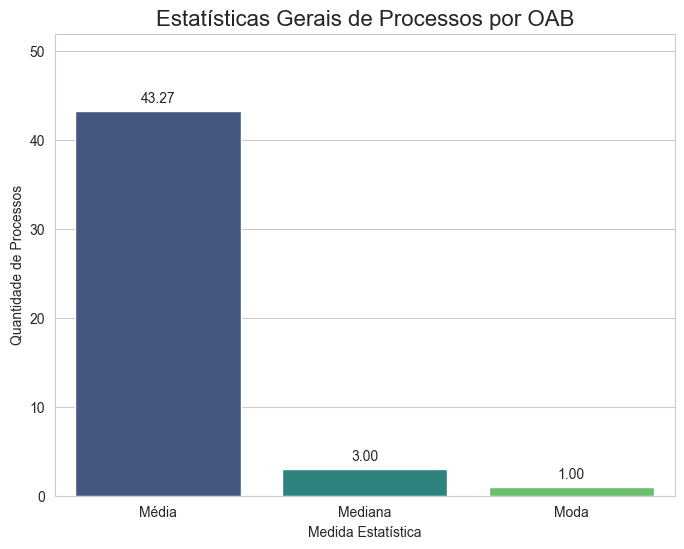

C:\Windows\Temp\ipykernel_12252\3519877140.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_nao_sigiloso = sns.barplot(x='Métrica', y='Valor', data=df_plot_nao_sigilosos, palette='plasma')


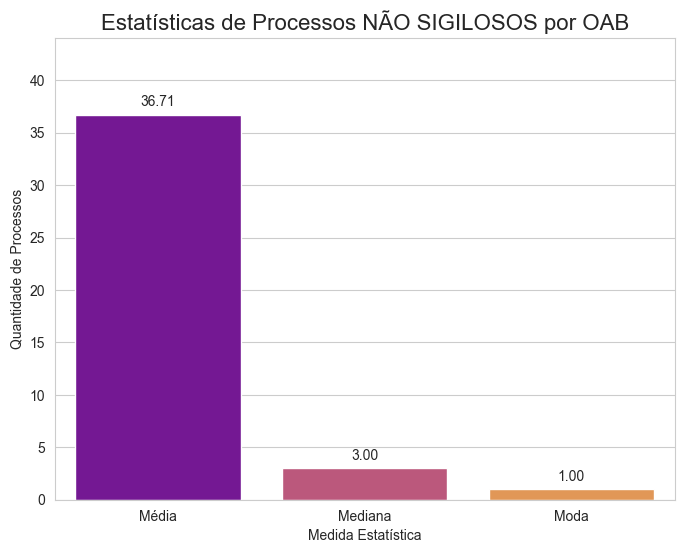

C:\Windows\Temp\ipykernel_12252\3519877140.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_sigiloso = sns.barplot(x='Métrica', y='Valor', data=df_plot_sigilosos, palette='cividis')


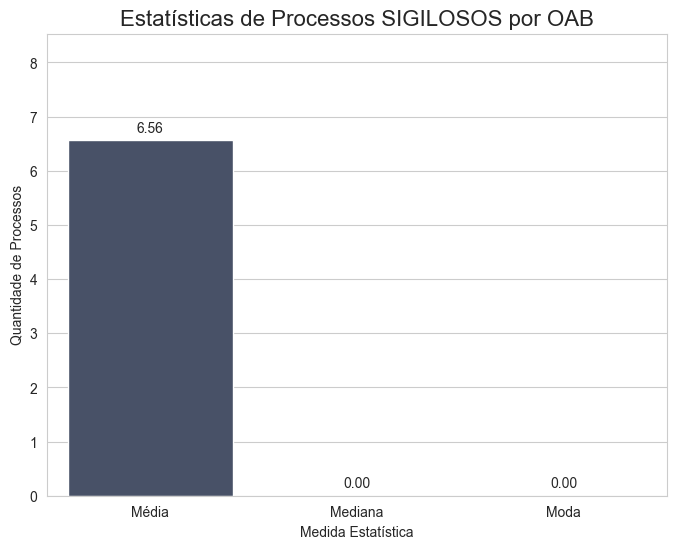

In [17]:
# 5) Visualização Gráfica das Estatísticas
# Configurar um estilo estético para os gráficos
sns.set_style("whitegrid")
sns.set_palette("viridis")

print("\n" + "="*100)
print("=== VISUALIZAÇÃO GRÁFICA DAS ESTATÍSTICAS ===")
print("="*100 + "\n")

# --- 5.1) Gráfico para Análise Geral ---

# Preparar os dados para o gráfico
dados_geral = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_geral, mediana_geral, moda_geral.iloc[0] if not moda_geral.empty else 0]
}
df_plot_geral = pd.DataFrame(dados_geral)

# Criar o gráfico
plt.figure(figsize=(8, 6)) # Define o tamanho da figura
ax_geral = sns.barplot(x='Métrica', y='Valor', data=df_plot_geral, palette='viridis')

# Adicionar o valor exato no topo de cada coluna
for p in ax_geral.patches:
    ax_geral.annotate(f'{p.get_height():.2f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Estatísticas Gerais de Processos por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_geral * 1.2) # Ajustar o limite do eixo Y para melhor visualização
plt.show()


# --- 5.2) Gráfico para Processos NÃO SIGILOSOS ---

# Preparar os dados para o gráfico
dados_nao_sigilosos = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_nao_sigilosos, mediana_nao_sigilosos, moda_nao_sigilosos.iloc[0] if not moda_nao_sigilosos.empty else 0]
}
df_plot_nao_sigilosos = pd.DataFrame(dados_nao_sigilosos)

# Criar o gráfico
plt.figure(figsize=(8, 6))
ax_nao_sigiloso = sns.barplot(x='Métrica', y='Valor', data=df_plot_nao_sigilosos, palette='plasma')

# Adicionar o valor exato no topo de cada coluna
for p in ax_nao_sigiloso.patches:
    ax_nao_sigiloso.annotate(f'{p.get_height():.2f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points')

plt.title('Estatísticas de Processos NÃO SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_nao_sigilosos * 1.2)
plt.show()


# --- 5.3) Gráfico para Processos SIGILOSOS ---

# Preparar os dados para o gráfico
dados_sigilosos = {
    'Métrica': ['Média', 'Mediana', 'Moda'],
    'Valor': [media_sigilosos, mediana_sigilosos, moda_sigilosos.iloc[0] if not moda_sigilosos.empty else 0]
}
df_plot_sigilosos = pd.DataFrame(dados_sigilosos)

# Criar o gráfico
plt.figure(figsize=(8, 6))
ax_sigiloso = sns.barplot(x='Métrica', y='Valor', data=df_plot_sigilosos, palette='cividis')

# Adicionar o valor exato no topo de cada coluna
for p in ax_sigiloso.patches:
    ax_sigiloso.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

plt.title('Estatísticas de Processos SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estatística')
plt.ylim(0, media_sigilosos * 1.3) # Um pouco mais de espaço para o rótulo
plt.show()